In this notebook, we'll perform exploratory data analysis on devices training dataset

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [2]:
# Load train and test data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [3]:
def compare_train_test(train_data, test_data):
    
    # Compare shape
    print("Shape Comparison:")
    print("Train Data Shape:", train_data.shape)
    print("Test Data Shape:", test_data.shape)
    print()
    
    # Compare null values
    print("Null Values Comparison:")
    train_null_count = train_data.isnull().any(axis=1).sum()
    test_null_count = test_data.isnull().any(axis=1).sum()
    print("Train Data Null Count:")
    print(train_null_count)
    print("Test Data Null Count:")
    print(test_null_count)
    print()
    
    print("Data types comparison of train and test sets' attributes")
    attr_name = train_data.dtypes[:-1].index.to_list()
    
    # Define a comparison dataframe and make the index the features' names
    comparison_df = pd.DataFrame(columns=['train_data','test_data'],index=attr_name)

    # Assign to each dataset's columns' dtypes
    comparison_df['train_data'] = train_data.dtypes[:-1].to_list()
    comparison_df['test_data'] = test_data.dtypes[1:].to_list()
    
    
    print(comparison_df)
  

In [4]:
def plot_correlation_heatmap(df):
    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()

In [5]:
  
def compare_distribution(train_data,test_data):
    # Scatter plot for each column
    print("Scatter Plot Comparison:")
    num_columns = len(train_data.columns)
    fig, axs = plt.subplots(num_columns, 2, figsize=(8, 5*num_columns))
    for i, col in enumerate(train_data.columns):
        axs[i, 0].scatter(train_data.index, train_data[col], label='Train')
        axs[i, 0].set_title(f"Train Data: {col} Scatter Plot")
        if col in test_data.columns:
            axs[i, 1].scatter(test_data.index, test_data[col], label='Test', color='orange')
            axs[i, 1].set_title(f"Test Data: {col} Scatter Plot")
        else:
            axs[i, 1].axis('off')  # Hide subplot if column not present in test data
        axs[i, 0].legend()
        axs[i, 1].legend()
    plt.tight_layout()
    plt.show()


In [6]:
def draw_histograms(df):
    # Loop over each column in the DataFrame
    for col in df.columns:
        # Draw histogram for the column
        plt.figure(figsize=(8, 6))
        sns.histplot(df[col], bins=20, kde=True)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()


In [7]:
compare_train_test(train_data,test_data)


Shape Comparison:
Train Data Shape: (2000, 21)
Test Data Shape: (1000, 21)

Null Values Comparison:
Train Data Null Count:
9
Test Data Null Count:
0

Data types comparison of train and test sets' attributes
              train_data test_data
battery_power      int64     int64
blue               int64     int64
clock_speed      float64   float64
dual_sim           int64     int64
fc               float64     int64
four_g           float64     int64
int_memory       float64     int64
m_dep            float64   float64
mobile_wt        float64     int64
n_cores          float64     int64
pc               float64     int64
px_height        float64     int64
px_width         float64     int64
ram              float64     int64
sc_h             float64     int64
sc_w             float64     int64
talk_time          int64     int64
three_g            int64     int64
touch_screen       int64     int64
wifi               int64     int64


In [8]:
train_data['int_memory']

0        7.0
1       53.0
2       41.0
3       10.0
4       44.0
        ... 
1995     2.0
1996    39.0
1997    36.0
1998    46.0
1999    45.0
Name: int_memory, Length: 2000, dtype: float64

Scatter Plot Comparison:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


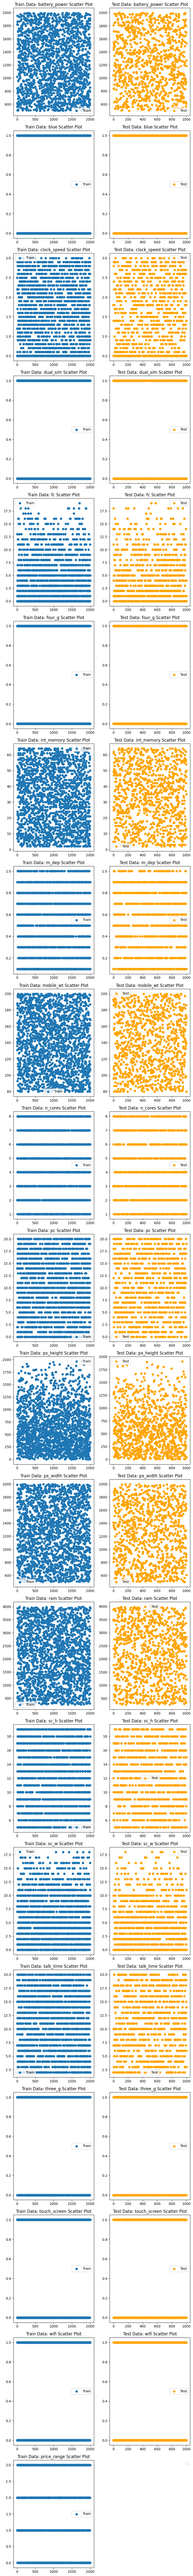

In [9]:
# Compare distribution of attributes in train and test data
compare_distribution(train_data,test_data)

In [10]:
print(" Checking class balance of the target variable in trainingset")
train_data['price_range'].value_counts()


 Checking class balance of the target variable in trainingset


price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64

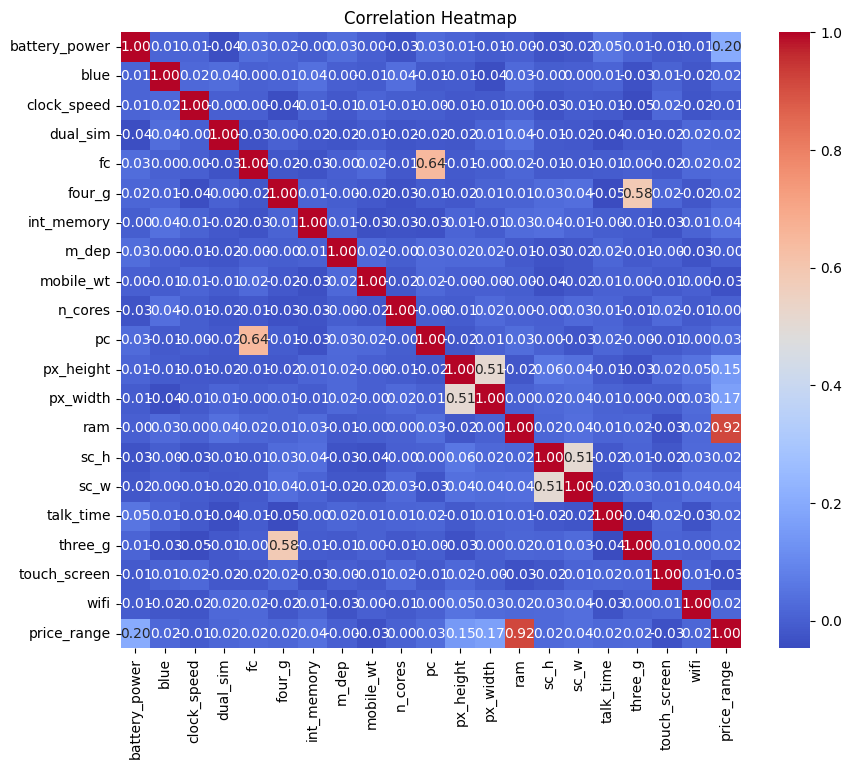

In [11]:
# Correlation plot
plot_correlation_heatmap(train_data)

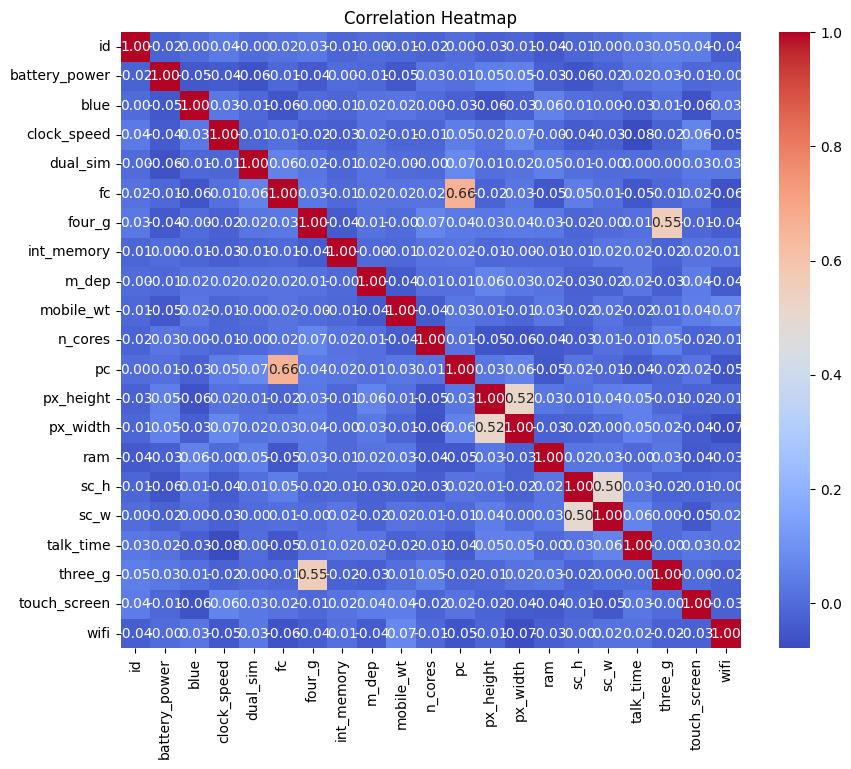

In [12]:
# Correlation plot for test data
plot_correlation_heatmap(test_data)

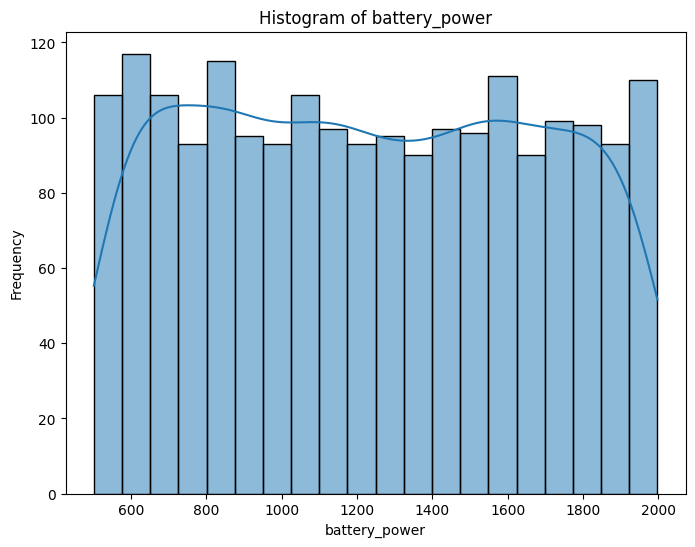

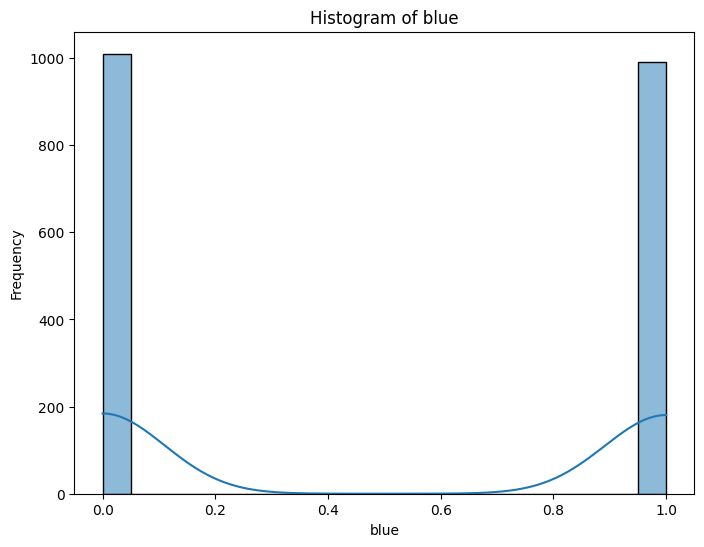

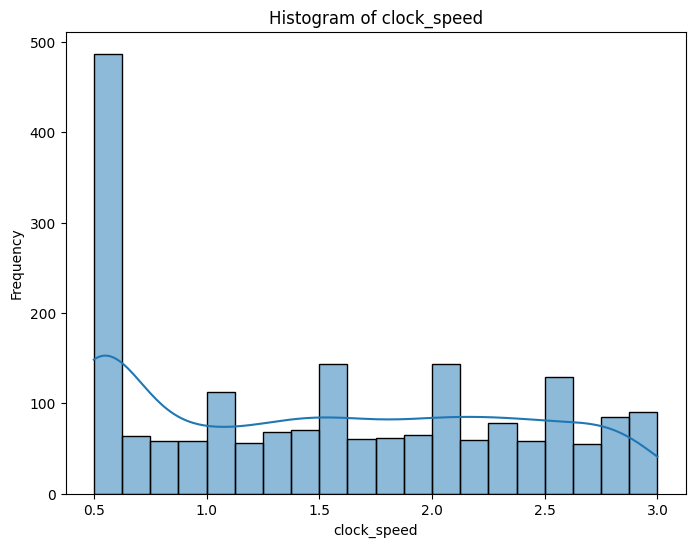

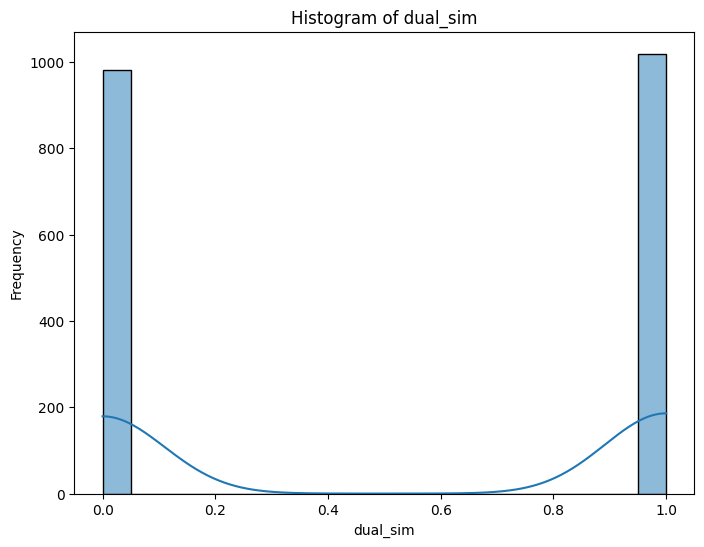

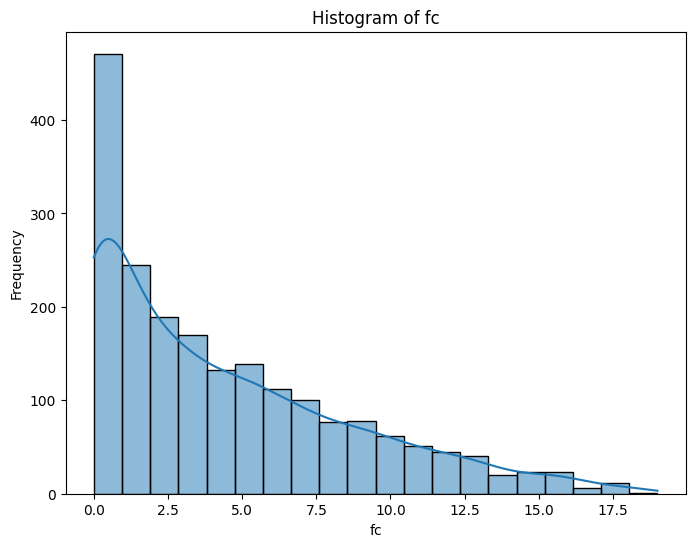

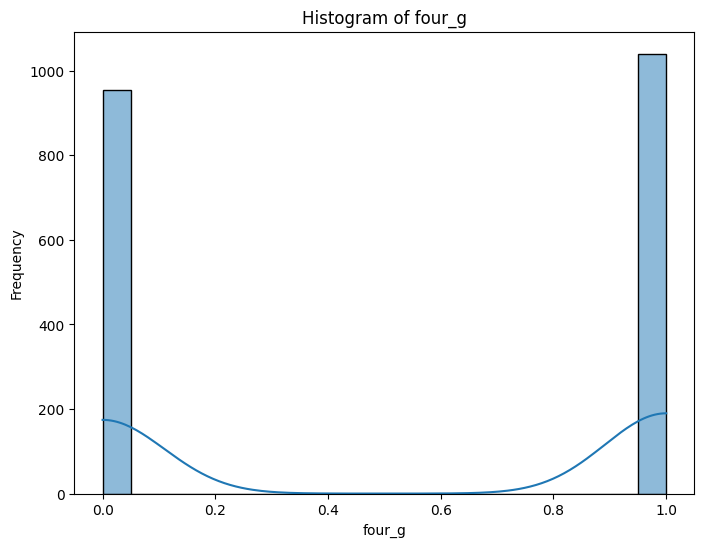

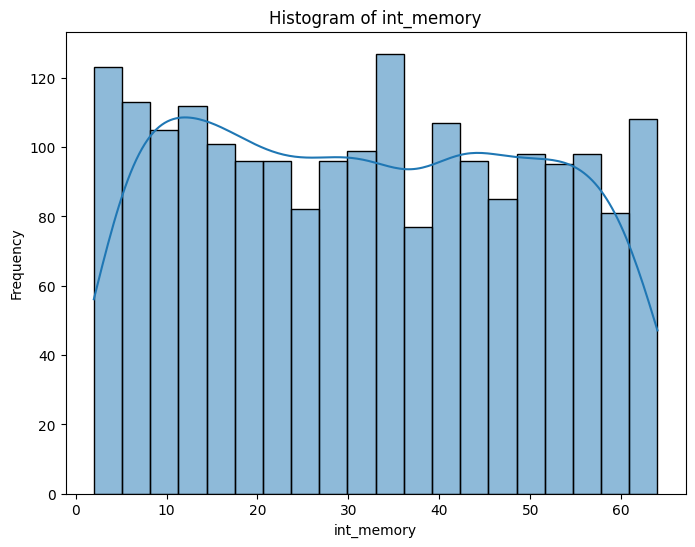

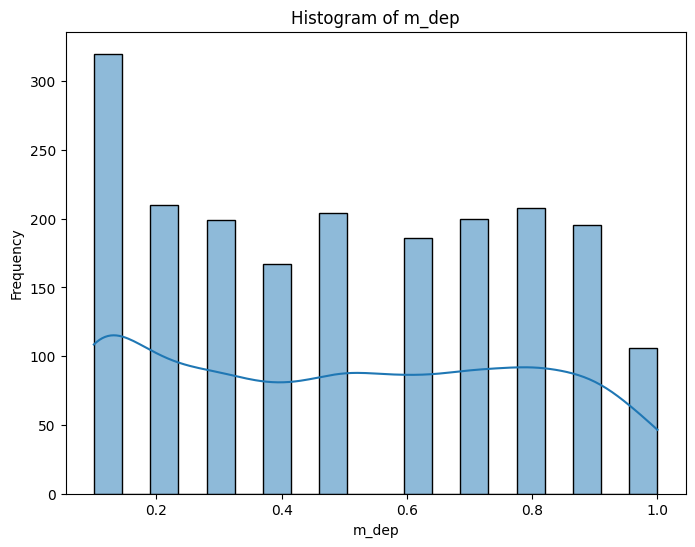

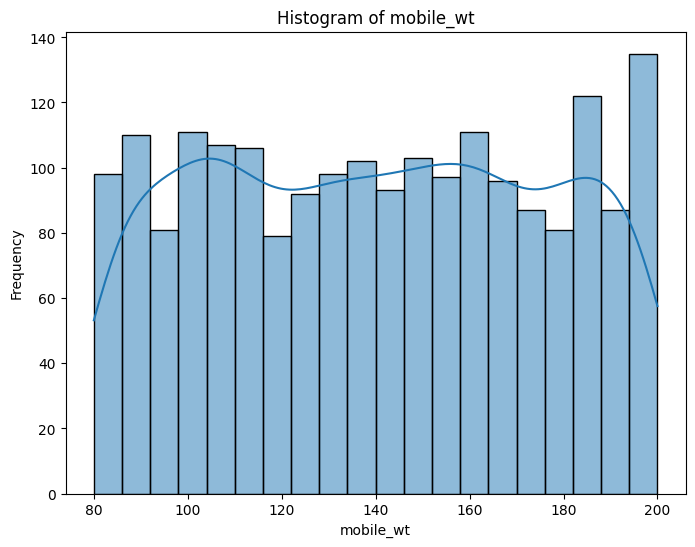

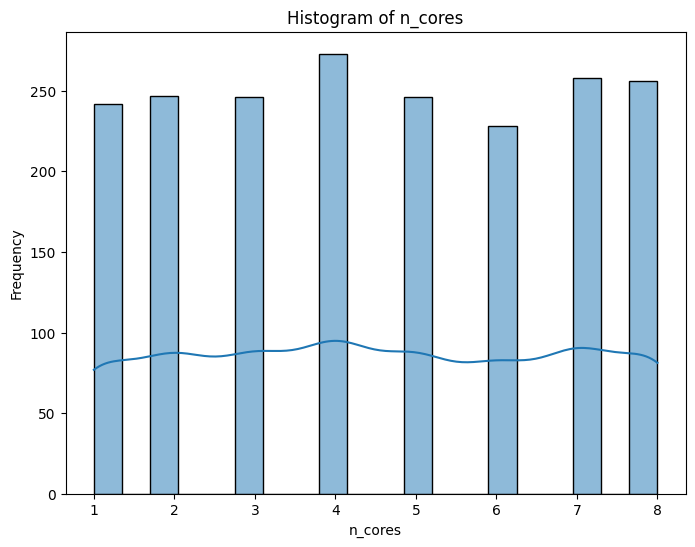

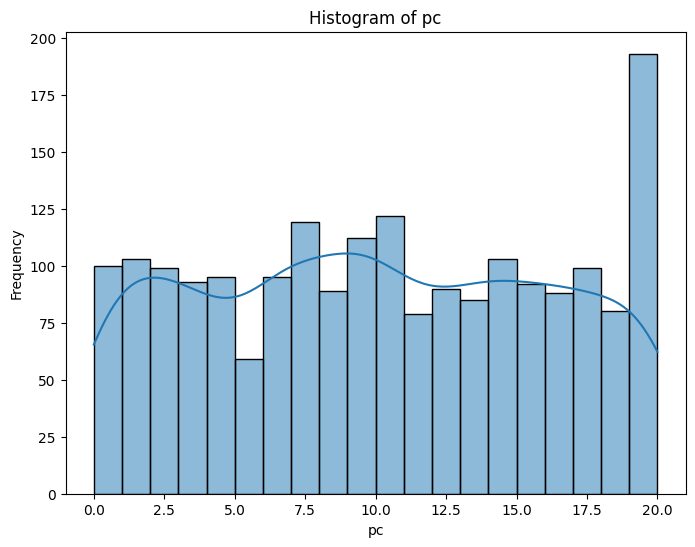

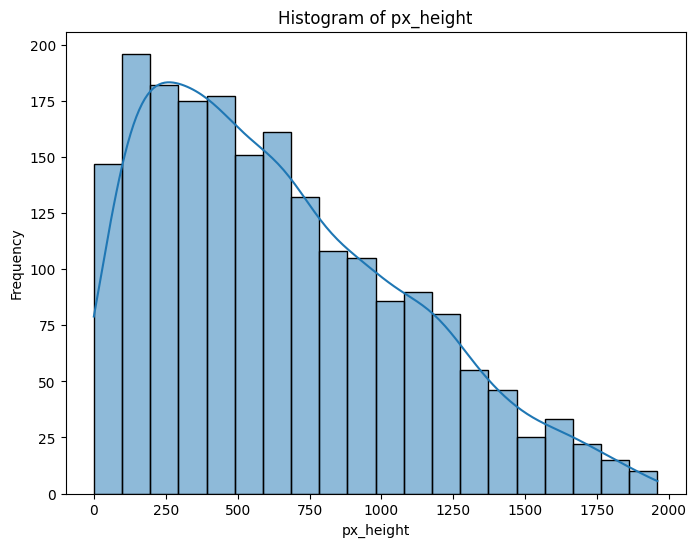

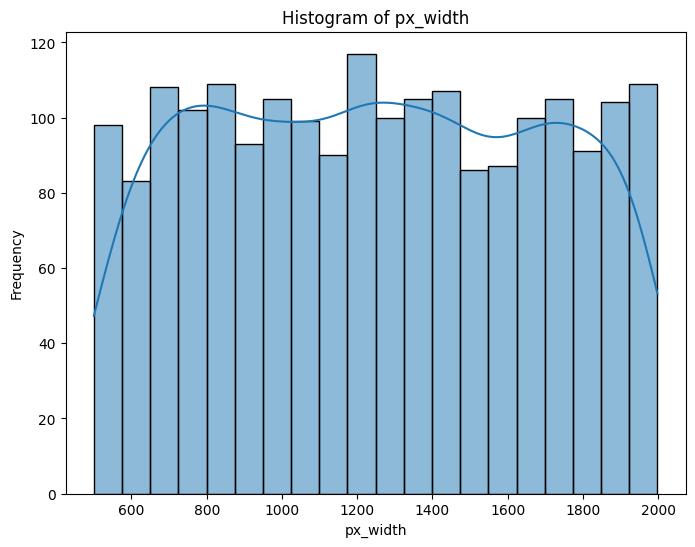

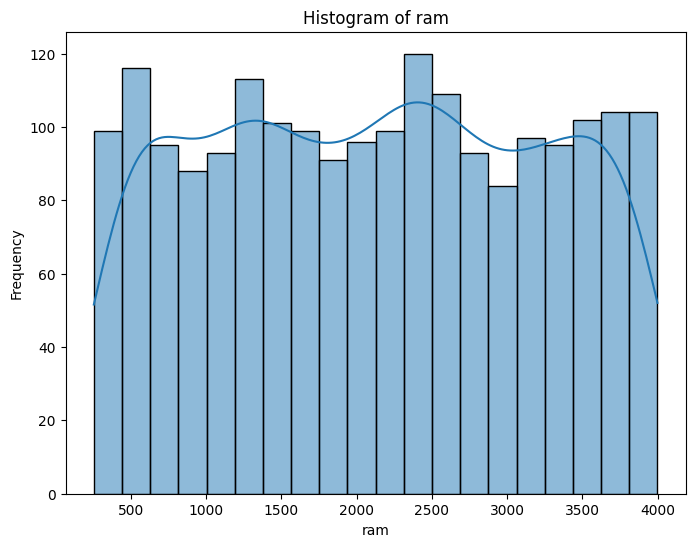

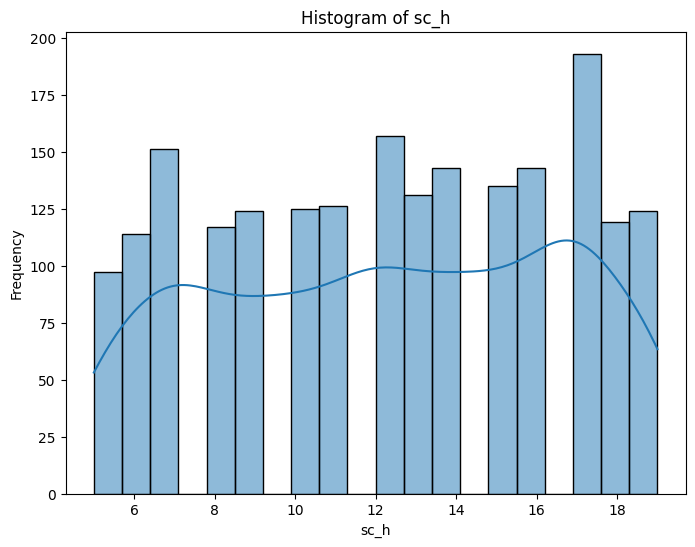

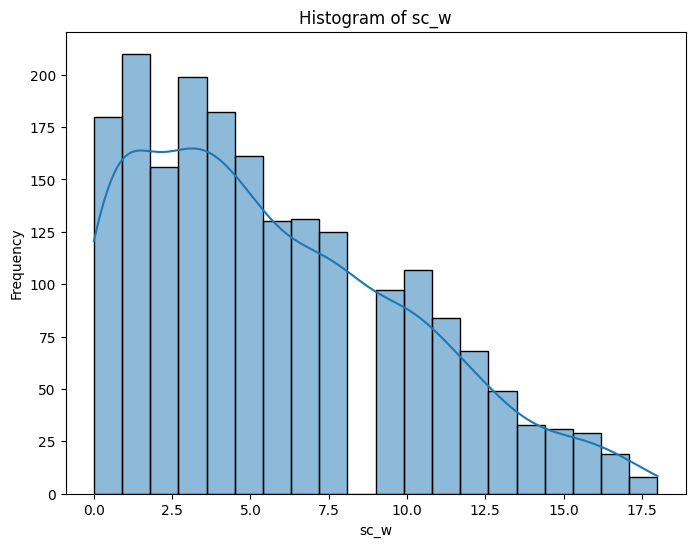

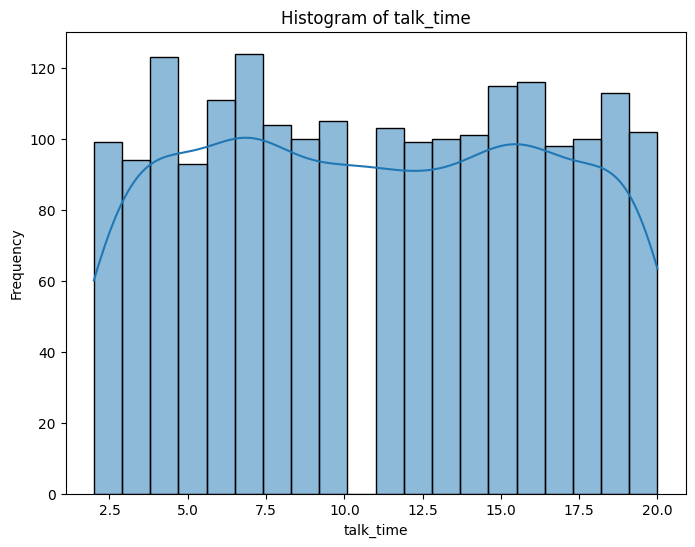

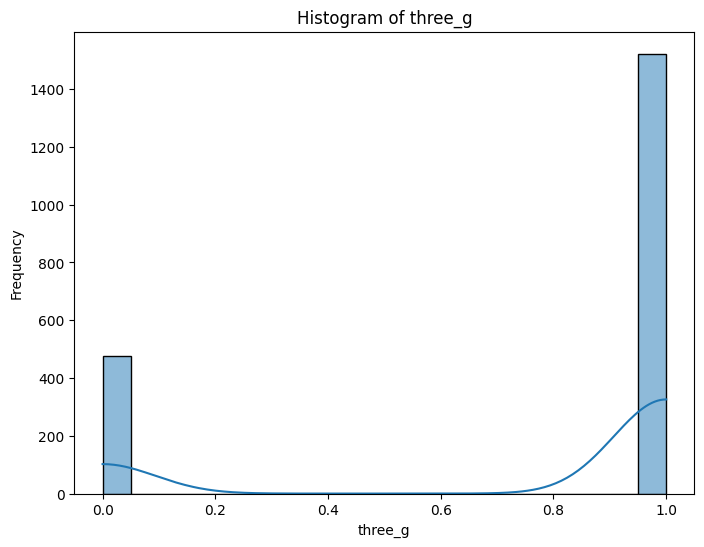

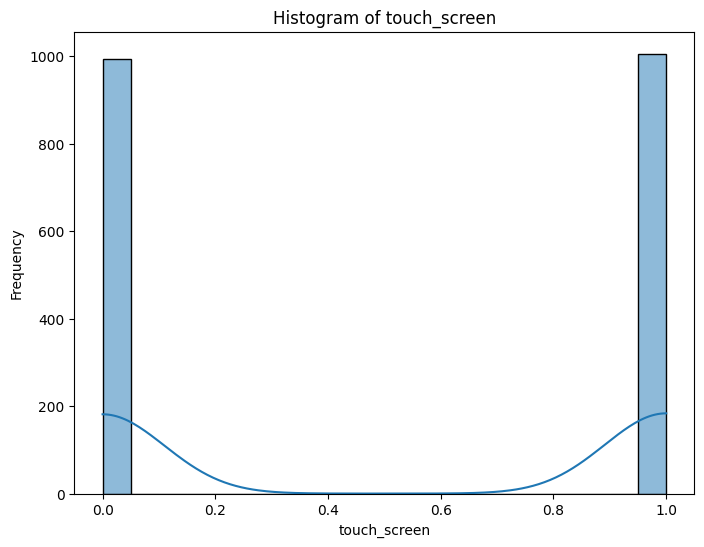

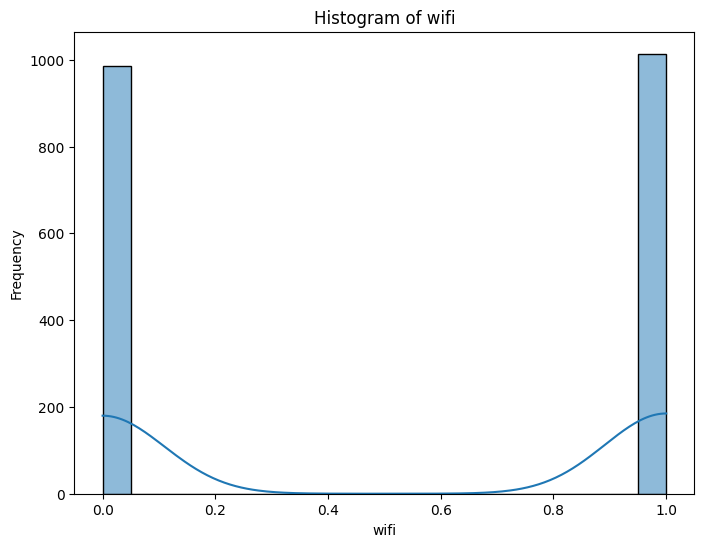

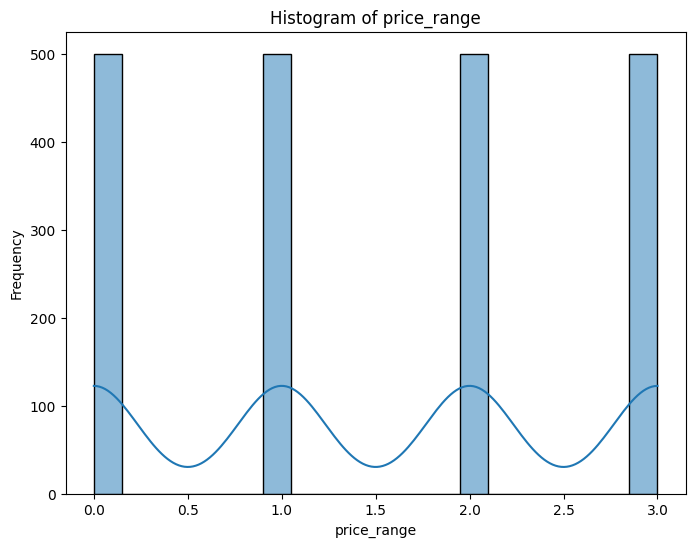

In [13]:
draw_histograms(train_data)

### Insights on train and test sets
1. Both train and test sets have 21 attribute but train set has the target variable `price_range` while test set doesn't. On the other hand, testset has an extra column for id for each test record which does not exist in trainset.
2. Trainset has 9 records that have nulls while testset doesn't have any.
3. Data types of attributes on both train and test sets are not consistent.
4. Train and test sets follow same distribution of attributes.
5. The target variable `price_range` in trainset is perfectly balanced which means there shouldn't be any bias to any class.
6. `ram` feature is highly correlated with the target variable `price_range` which means it likely carries significant predictive power.
7. There are features that are highly correlated in train and test sets
    1. like `fc` and `pc` which makes since for technology adaption that if front camera resolution increase, the primary camera resolution increases as well.
    2. Also `px_height` and `px_width` which makes since for device size comptability.
    3. Also `three_g` and `four_g` which makes since that devices that support 3G also supports 4G for technology adaption as well.
- There correlation features represent multicollinearity which can affect model convergence, so we will need to do some feature engineering to handle them.



### Feature Engineering
There are a couple of things that we will need to deal in this part to prepare the data for our machine learning model
1. Drop rows that have null as they are only 9 records.
2. Make the attributes' data types of both train and test sets consistent.
3. Create new features out of correlated features.
4. Scale the numerical data.

#### Drop records

In [14]:
# Drop rows of null values
train_data.dropna(inplace=True)

#Verify dropped records
train_data.isnull().sum().sum()

0

#### Change data types

- in train:
    - fc: int
    - four_g: int
    - int_memory: int
    - n_cores: int

- in test:
    - mobile_wt: float
    - fc: float
    - pc: float
    - px_height: float
    - px_width: float
    - ram: float
    - sc_h: float
    - sc_w: float

In [15]:
# Change data types of some attributes in training set
train_col_to_convert = ['fc','four_g','int_memory','n_cores']
train_data[train_col_to_convert] = train_data[train_col_to_convert].astype(int)
train_data['price_range'] = train_data['price_range'].astype('category')

# Change data types of some attributes in test set
test_col_to_convert = ['mobile_wt', 'fc', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w']
test_data[test_col_to_convert] = test_data[test_col_to_convert ].astype(float)


In [16]:
# Feature engineering function
def feature_engineering(df):  
    # Create new feature 'mob_vol' by multiplying 'sc_h', 'sc_w', and 'm_dep'
    df['mob_vol'] = df['sc_h'] * df['sc_w'] * df['m_dep']
    df['px_dims'] = df['px_height'] * df['px_width']
    
    # Drop original features  
    df.drop(['sc_h', 'sc_w', 'm_dep', 'px_width', 'px_height'], axis=1, inplace=True)
    
    return df




feature_engineering_step = FunctionTransformer(feature_engineering)

# Scaling specified columns
preprocessor = ColumnTransformer(transformers=[
    ('scaling', StandardScaler(), ['battery_power', 'clock_speed', 'fc', 
                                   'int_memory', 'mobile_wt', 'n_cores', 'pc', 
                                   'px_dims', 'ram', 'talk_time'])],
                                remainder='passthrough') 

 

# Create pipeline
pipeline = Pipeline(steps=[
    ('feature_engineering', feature_engineering_step),
    ('preprocessor', preprocessor),
    ('DTclassifier', DecisionTreeClassifier(max_depth=10)) 
])





In [17]:
# Fit pipeline
X = train_data.drop(columns=['price_range'])
y = train_data['price_range']
pipeline.fit(X, y)

Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x7bd6665d9ea0>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'mobile_wt',
                                                   'n_cores', 'pc', 'px_dims',
                                                   'ram', 'talk_time'])])),
                ('DTclassifier', DecisionTreeClassifier(max_depth=10))])

In [18]:
# Evaluate pipeline
accuracy = pipeline.score(train_data.drop(columns=['price_range']), train_data['price_range'])
print("Accuracy:", accuracy)

Accuracy: 0.9904570567553993


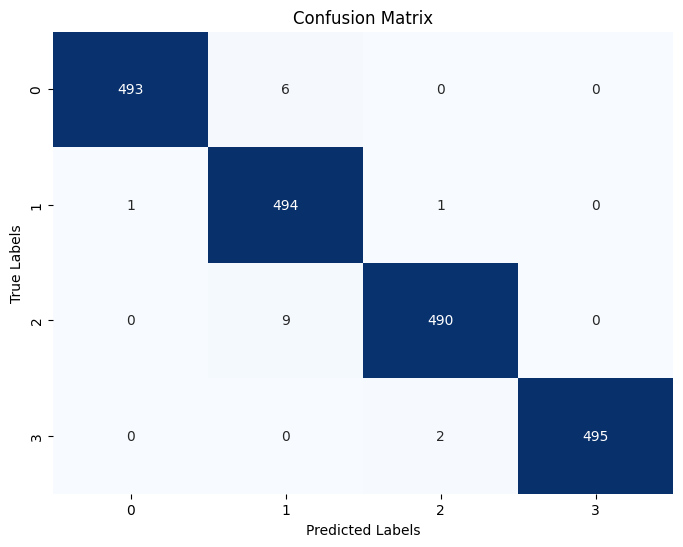

In [19]:
X_pred = pipeline.predict(train_data.drop(columns=['price_range']))
# Calculate the confusion matrix
conf_matrix = metrics.confusion_matrix(train_data['price_range'], X_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Let's try to get the same result with less features
We'll try using the most correlated features.

In [20]:
# Calculate correlation
cor =  train_data.corr()

# Get the absolute value of the correlation
cor_target = abs(cor["price_range"])

# Select highly correlated features (thresold = 0.1)
relevant_features = cor_target[cor_target>=0.1]

print(relevant_features.index)



Index(['battery_power', 'px_height', 'px_width', 'ram', 'price_range'], dtype='object')


Edited feature engineering and pipeline

In [34]:

# Feature engineering function
def feature_engineering(df):  
    # Keep only important features 
    df = df.loc[:,['battery_power', 'px_height', 'px_width', 'ram']]
    
    #Combine two features
    df['px_dims'] = df['px_height'] * df['px_width']
    
    # Drop original features  
    df.drop(['px_width', 'px_height'], axis=1, inplace=True)
    
    return df

feature_engineering_step = FunctionTransformer(feature_engineering)

# Scaling specified columns
preprocessor = ColumnTransformer(transformers=[
    ('scaling', StandardScaler(), ['battery_power', 'px_dims', 'ram'])],
                                remainder='passthrough') 

 

# Create pipeline
pipeline = Pipeline(steps=[
    ('feature_engineering', feature_engineering_step),
    ('preprocessor', preprocessor),
    ('DTclassifier', DecisionTreeClassifier(max_depth=10)) 
])





In [35]:
# Fit pipeline
X = train_data
y = train_data['price_range']
pipeline.fit(X, y)


Pipeline(steps=[('feature_engineering',
                 FunctionTransformer(func=<function feature_engineering at 0x7bd666738dc0>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaling', StandardScaler(),
                                                  ['battery_power', 'px_dims',
                                                   'ram'])])),
                ('DTclassifier', DecisionTreeClassifier(max_depth=10))])

In [37]:
X = train_data
y = train_data['price_range']
# Evaluate pipeline
accuracy = pipeline.score(X, y)
print("Accuracy:", accuracy)

Accuracy: 0.9909593169261678


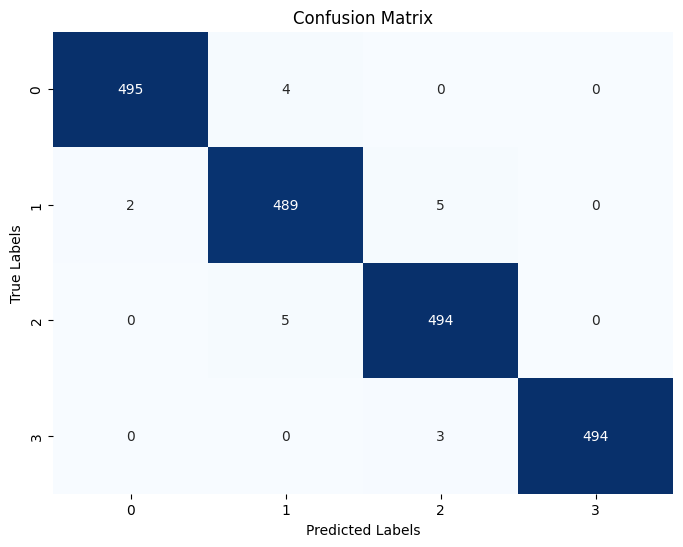

In [32]:
X_pred = pipeline.predict(train_data.drop(columns=['price_range']))
# Calculate the confusion matrix
conf_matrix = metrics.confusion_matrix(train_data['price_range'], X_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Voila!! We got the same result with only 4 features instead of 20!

Now, let's predict the test data results

In [33]:
y_pred = pipeline.predict(test_data)

In [28]:
y_pred

array([3, 3, 2, 3, 1, 3, 3, 1, 3, 0, 3, 3, 0, 0, 2, 0, 2, 1, 3, 2, 0, 3,
       1, 1, 3, 0, 2, 0, 3, 0, 2, 0, 3, 0, 0, 1, 3, 2, 2, 1, 1, 2, 0, 0,
       0, 1, 0, 3, 1, 2, 1, 1, 2, 0, 3, 1, 3, 1, 1, 3, 3, 2, 0, 1, 1, 0,
       1, 3, 1, 2, 1, 2, 2, 3, 3, 0, 2, 0, 2, 3, 1, 3, 3, 0, 3, 0, 3, 1,
       2, 0, 1, 2, 2, 0, 2, 2, 0, 2, 1, 2, 1, 0, 0, 3, 0, 2, 0, 1, 2, 3,
       3, 3, 1, 3, 3, 3, 3, 1, 3, 0, 0, 3, 2, 1, 1, 0, 3, 2, 3, 1, 0, 2,
       1, 0, 3, 0, 1, 0, 3, 2, 1, 3, 1, 3, 2, 3, 3, 2, 2, 3, 2, 3, 0, 0,
       3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 0, 0, 3, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 2, 1, 0, 0, 0, 1, 3, 2, 1, 0, 0, 0, 0, 0, 3, 1, 0, 2, 2,
       3, 3, 1, 1, 3, 3, 3, 2, 1, 1, 0, 0, 1, 3, 0, 2, 3, 3, 0, 2, 0, 3,
       1, 3, 3, 1, 0, 1, 0, 3, 0, 1, 0, 2, 2, 1, 3, 1, 2, 0, 3, 1, 2, 0,
       0, 2, 1, 3, 3, 3, 1, 1, 3, 0, 0, 2, 3, 3, 1, 3, 2, 1, 3, 2, 1, 2,
       3, 3, 3, 1, 0, 0, 2, 3, 2, 1, 3, 2, 0, 3, 0, 1, 3, 1, 0, 3, 3, 3,
       3, 2, 1, 3, 3, 2, 3, 1, 3, 1, 2, 0, 2, 3, 1,

In [27]:
import pickle

# Save the trained pipeline to a file
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)


In [41]:
with open('trained_model.pkl', "rb") as f:
    data = pickle.load(f)


In [63]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1991 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   battery_power  1991 non-null   int64   
 1   blue           1991 non-null   int64   
 2   clock_speed    1991 non-null   float64 
 3   dual_sim       1991 non-null   int64   
 4   fc             1991 non-null   int64   
 5   four_g         1991 non-null   int64   
 6   int_memory     1991 non-null   int64   
 7   m_dep          1991 non-null   float64 
 8   mobile_wt      1991 non-null   float64 
 9   n_cores        1991 non-null   int64   
 10  pc             1991 non-null   float64 
 11  px_height      1991 non-null   float64 
 12  px_width       1991 non-null   float64 
 13  ram            1991 non-null   float64 
 14  sc_h           1991 non-null   float64 
 15  sc_w           1991 non-null   float64 
 16  talk_time      1991 non-null   int64   
 17  three_g        1991 non-null   int64  

In [66]:
import requests

# URL of your Flask API endpoint
url = 'http://localhost:5000/predict'  

# Device specifications for prediction
device_specs = {
    'battery_power': 1500,
    'blue': 1,
    'clock_speed': 2.0,
    'dual_sim': 1,
    'fc': 5,
    'four_g': 1,
    'int_memory': 32,
    'm_dep': 0.3,
    'mobile_wt': 150,
    'n_cores': 8,
    'pc': 10,
    'px_height': 800.0,
    'px_width': 1600.0,
    'ram': 4096.0,
    'sc_h': 5,
    'sc_w': 4,
    'talk_time': 20,
    'three_g': 1,
    'touch_screen': 1,
    'wifi': 1
}

# Send POST request to the Flask API endpoint
response = requests.post(url, json=device_specs)

# Check if request was successful (status code 200)
if response.status_code == 200:
    # Extract predicted price from response
    predicted_price = response.json()['predicted_price']
    print(f'Predicted Price: {predicted_price}')
else:
    print(f'Error: {response.text}')


Predicted Price: 3
